### Information Retrieval Mid Test

### Mesyella/2201793281

### Case

In [1]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import pandas as pd
import numpy as np
import nltk
import re


data = pd.read_csv('review_data.csv')
dataKamar = np.array(data['room'])
data = np.array(data['review'])

### Preprocessing

In [2]:
lower = []
for word in data:
    new = word.lower()
    lower.append(new)

In [3]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

stop = []
for word in lower:
    new = stopword.remove(word)
    stop.append(new)

In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stem = []
for word in stop:
    new = stemmer.stem(word)
    stem.append(new)

In [5]:
punc = []
for word in stem:
    new = re.sub(r'[^\w\s]', '', word)
    if new != '':
        punc.append(new)

In [6]:
nonum = []
for word in punc:
    new = re.sub(r'\d+', '', word)
    if new != '':
        nonum.append(new)

In [7]:
tokenize = []
for i in range(np.array(nonum).shape[0]):
    words = nltk.word_tokenize(nonum[i])
    tokenize.append(words)

### TF-IDF

In [8]:
DF = {}
N = len(tokenize)
for i in range(N):
    tokens = tokenize[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
            
for i in DF:
    DF[i] = len(DF[i])

total_vocab_size = len(DF)

In [9]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [10]:
doc = 0
tf_idf = {}

for i in range(N):
    tokens = tokenize[i]
    counter = Counter(tokens)
    words_count = len(tokens)
    for token in np.unique(tokens):
        tf = counter[token]/words_count
        docF = doc_freq(token)
        idf = np.log((N+1)/(docF+1))
        tf_idf[doc, token] = tf*idf

    doc += 1

###  Unigram/Query likelihood language model and linear interpolation smoothing 

In [11]:
def match(q):
    probTemp = []
    total = 0
    totalAll = 0
    probWord = 0
    for i in range(len(tokenize)):
        c = 0 
        for word in tokenize[i]:
            totalAll += 1
            if(word==q):
                c+=1
                total+=1
        probWord = c / len(tokenize[i])
        probTemp.append(probWord)
    probAll = total/totalAll
    return probTemp, probAll
    

### Matching with TF-IDF

In [12]:
def matching_score(query):
    tokens = nltk.word_tokenize(str(query))
    query_weights = {}
    for key in tf_idf: 
        if key[1] in tokens:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
    l = []
    
    for i in query_weights[:5]:
        l.append(i[0])
    
    return l;

In [13]:
print("Top 5 room match with 'kamar sangat nyaman' using tf-idf:")
nyaman = matching_score('kamar sangat nyaman')
for i in nyaman:
    print("room", dataKamar[i],":", nonum[i])

Top 5 room match with 'kamar sangat nyaman' using tf-idf:
room 11 : ac dingin sangat kurang nyaman
room 19 : layan manajemen hotel sangat sangat buruk jelek
room 18 : tempat bersih nyaman cuman wifi sangat sangat lot banget makasih
room 3 : nyaman ac bocor
room 13 : kamar mandi sangat bau yg lain bagus nyaman


In [14]:
print("Top 5 room  with 'kamar jorok dan kotor' using tf-idf:")
kotor = matching_score('kamar jorok kotor')
for i in kotor:
    print("room", dataKamar[i],":", nonum[i])

Top 5 room  with 'kamar jorok dan kotor' using tf-idf:
room 12 : jorok sekali
room 1 : kotor
room 3 : kotor
room 10 : kamar kotor
room 13 : kamar kotor


### Matching with unigram/query likelihood language model and linear interpolation smoothing 

#### kamar sangat nyaman

In [15]:
kamar, probKamar = match("kamar")
kamar = np.array(kamar)
kamar = (0.5*kamar)+((1-0.5)*probKamar)
sangat, probSangat = match("sangat")
sangat = np.array(sangat)
sangat = (0.5*sangat)+((1-0.5)*probSangat)
nyaman, probNyaman = match("nyaman")
nyaman = np.array(nyaman)
nyaman = (0.5*nyaman)+((1-0.5)*probNyaman)
total = kamar * sangat * nyaman
pr = {}
for i in range(len(total)):
    pr[i] = total[i]
    
pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)
print("Top 5 room with 'kamar sangat nyaman' using linear interpolation:")
for i in pr[:5]:
    print("room",dataKamar[i[0]],":", nonum[i[0]])

Top 5 room with 'kamar sangat nyaman' using linear interpolation:
room 13 : kamar mandi sangat bau yg lain bagus nyaman
room 11 : ac dingin sangat kurang nyaman
room 12 : kamar mandi kotor layan sangat baik staf ramah sama sekali nyaman
room 18 : tempat bersih nyaman cuman wifi sangat sangat lot banget makasih
room 9 : lokasi strategis mudah temu kamar nyaman fasilitas wifi sangat kurang jenis makan


#### kamar jorok dan kotor

In [16]:
kamar, probKamar = match("kamar")
kamar = np.array(kamar)
kamar = (0.5*kamar)+((1-0.5)*probKamar)
jorok, probJorok = match("jorok")
jorok = np.array(jorok)
jorok = (0.5*jorok)+((1-0.5)*probJorok)
kotor, probKotor = match("kotor")
kotor = np.array(kotor)
kotor = (0.5*kotor)+((1-0.5)*probKotor)
total = kamar * jorok * kotor
pr = {}
for i in range(len(total)):
    pr[i] = total[i]
    
pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)
print("Top 5 room  with 'kamar jorok dan kotor' using linear interpolation:")
for i in pr[:5]:
    print("room",dataKamar[i[0]],":", nonum[i[0]])

Top 5 room  with 'kamar jorok dan kotor' using linear interpolation:
room 15 : kotor ada air jorok nyaman
room 3 : rekomendasi kamar no  tembok kotor banyak nyamuk wc bau kamar mandi jorok
room 18 : datang jam  siang tidak cek in kamar kotor hotel ramai jorok
room 14 : kamar sempit bau jorok
room 5 : masuk gang nya kotor jorok kamar nya sempit kamar mandi kotor ac nya lama banget dingin nya kecewa ga ygdi tampil foto


From the results, when we compare, the tf-idf query and linear interpolation smoothing results show different rooms for top 5 room with given query. This is cause by the different calculation between TF-IDF and Unigram Linear Interpolation smoothing. TF-IDF result doesn't have smoothing that's why they use sum of the value. Linear Interpolation Smoothing use multiplication of the unigram probability value. If I have too choose I will use linear interpolation smoothing which shows better results for the matching.

### Based on your knowledge, how you can use linear interpolation smoothing approach to extract 5 top keywords for each room?

Smoothing is used to decrease the probability of observed outcomes and increase the probability of unobserved outcomes. One of the smoothing approach is called linear interpolation. Linear interpolation helps us to avoid zero-probabilities. It’s important because we want to multiply the probabilities. Linear interpolation uses IDF-like scoring of documents where terms that less frequent in the entire collections have higher contribution to a document’s score. To extract the top 5 keywords from each room we calculate it with the formula:

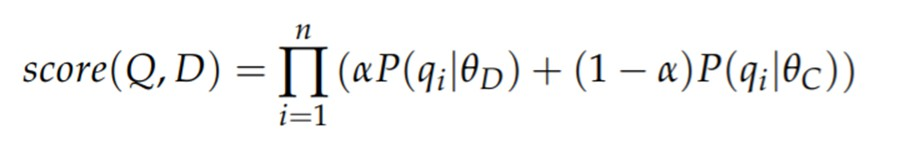

Then we will get the score for each query in document and compare it with other and show the top 5 keywords.

### References:

https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/07-QueryLikelihoodModel.pdf

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://medium.com/@ksnugroho/dasar-text-preprocessing-dengan-python-a4fa52608ffe